In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tqdm import tqdm
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Bidirectional,Dropout,concatenate,Embedding,Dot,Activation,RepeatVector,Multiply,Lambda

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
model=VGG16()
model=Model(inputs=model.inputs,outputs=model.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [3]:
input_dir='D:\Projects\IMG-CAPTION\dataset'
output_dir='D:\Projects\IMG-CAPTION'

In [4]:
image_features={}

img_dir=os.path.join(input_dir,'Images')
for img_name in tqdm(os.listdir(img_dir)):
    img_path=os.path.join(img_dir,img_name)
    image=load_img(img_path,target_size=(224,224))
    image=img_to_array(image)
    image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    image=preprocess_input(image)
    image_feature=model.predict(image,verbose=0)
    image_id=img_name.split('.')[0]
    image_features[image_id]=image_feature

100%|██████████| 8091/8091 [11:28<00:00, 11.75it/s]


In [5]:
pickle.dump(image_features,open(os.path.join(output_dir,'image_features.pkl'),'wb'))

In [6]:
pickle_file_path=os.path.join(output_dir,"image_features.pkl")
with open(pickle_file_path,'rb') as fp:
    loaded_features=pickle.load(fp)


In [7]:
with open(os.path.join(input_dir,"captions.txt"),'r') as fp:
    next(fp)
    captions_doc=fp.read()

In [8]:
from collections import defaultdict
img_to_cap_map=defaultdict(list)
for line in tqdm(captions_doc.split('\n')):
    tokens=line.split(',')
    if len(tokens) <2:
        continue
    image_id,*captions=tokens
    image_id=image_id.split('.')[0]
    caption=" ".join(captions)
    img_to_cap_map[image_id].append(caption)
total_captions=sum(len(caption) for capiton in img_to_cap_map.values())
print(total_captions)

  0%|          | 0/40456 [00:00<?, ?it/s]

100%|██████████| 40456/40456 [00:00<00:00, 1156576.19it/s]

404550


In [9]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = ''.join(char for char in caption if char.isalpha() or char.isspace())
            caption = ' '.join(caption.split())  # Normalize multiple spaces
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption  # ✅ Correct way to update the list


In [10]:
img_to_cap_map['1026685415_0431cbf574']

['A black dog carries a green toy in his mouth as he walks through the grass .',
 'A black dog carrying something through the grass .',
 'A black dog has a blue toy in its mouth .',
 'A dog in grass with a blue item in his mouth .',
 'A wet black dog is carrying a green toy through the grass .']

In [11]:
clean(img_to_cap_map)

In [12]:
img_to_cap_map['1026685415_0431cbf574']

['startseq black dog carries green toy in his mouth as he walks through the grass endseq',
 'startseq black dog carrying something through the grass endseq',
 'startseq black dog has blue toy in its mouth endseq',
 'startseq dog in grass with blue item in his mouth endseq',
 'startseq wet black dog is carrying green toy through the grass endseq']

In [13]:
all_captions = [caption for captions in img_to_cap_map.values() for caption in captions]


In [14]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [15]:
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

with open('tokenizer.pkl', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

In [16]:
max_caption_length = max(len(tokenizer.texts_to_sequences([caption])[0]) for caption in all_captions)
vocab_size = len(tokenizer.word_index) + 1

print("Vocabulary Size:", vocab_size)
print("Maximum Caption Length:", max_caption_length)

Vocabulary Size: 8768
Maximum Caption Length: 34


In [17]:
image_ids=list(img_to_cap_map.keys())
split=int(len(image_ids)*0.90)
train=image_ids[:split]
test=image_ids[split:]

In [18]:
# from tensorflow.keras.utils import Sequence
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# import numpy as np

# class CustomDataGenerator(Sequence):
#     def __init__(self, data_keys, img_to_cap_map, features, tokenizer, max_caption_length, vocab_size, batch_size, shuffle=True):
#         self.data_keys = data_keys
#         self.img_to_cap_map = img_to_cap_map
#         self.features = features
#         self.tokenizer = tokenizer
#         self.max_cap_len = max_caption_length
#         self.vocab_size = vocab_size
#         self.batch_size = batch_size
#         self.shuffle = shuffle
#         self.on_epoch_end()

#     def __len__(self):
#         return int(np.ceil(len(self.data_keys) / self.batch_size))

#     def __getitem__(self, index):
#         batch_keys = self.data_keys[index*self.batch_size:(index+1)*self.batch_size]
#         X1, X2, y = self.__get_data(batch_keys)
#         return [X1, X2], y

#     def on_epoch_end(self):
#         if self.shuffle:
#             np.random.shuffle(self.data_keys)

#     def __get_data(self, batch_keys):
#         X1, X2, y = [], [], []

#         for img_id in batch_keys:
#             feature = self.features[img_id][0]
#             captions = self.img_to_cap_map[img_id]
#             for caption in captions:
#                 seq = self.tokenizer.texts_to_sequences([caption])[0]
#                 for i in range(1, len(seq)):
#                     in_seq, out_seq = seq[:i], seq[i]
#                     in_seq = pad_sequences([in_seq], maxlen=self.max_cap_len)[0]
#                     out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
#                     X1.append(feature)
#                     X2.append(in_seq)
#                     y.append(out_seq)

#         return np.array(X1), np.array(X2), np.array(y)

def data_generator(data_keys, image_to_captions_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    X1_batch, X2_batch, y_batch = [], [], []
    batch_count = 0

    while True:
        for image_id in data_keys: 
            captions = image_to_captions_mapping[image_id]
            for caption in captions:
                caption_seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(caption_seq)):
                    in_seq, out_seq = caption_seq[:i], caption_seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1_batch.append(features[image_id][0])  
                    X2_batch.append(in_seq) 
                    y_batch.append(out_seq) 
                    batch_count += 1

                    if batch_count == batch_size:
                        X1_batch, X2_batch, y_batch = np.array(X1_batch), np.array(X2_batch), np.array(y_batch)
                        yield [X1_batch, X2_batch], y_batch
                        X1_batch, X2_batch, y_batch = [], [], []
                        batch_count = 0

In [19]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
fe2_projected = RepeatVector(max_caption_length)(fe2)
fe2_projected = Bidirectional(LSTM(256, return_sequences=True))(fe2_projected)

inputs2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)

attention = Dot(axes=[2, 2])([fe2_projected, se3])  

attention_scores = Activation('softmax')(attention)

attention_context = Lambda(lambda x: tf.einsum('ijk,ijl->ikl', x[0], x[1]))([attention_scores, se3])

context_vector = tf.reduce_sum(attention_context, axis=1)

decoder_input = concatenate([context_vector, fe2], axis=-1)
decoder1 = Dense(256, activation='relu')(decoder_input)
outputs = Dense(vocab_size, activation='softmax')(decoder1)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [20]:
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# model_name = "model.h5"
# checkpoint = ModelCheckpoint(model_name,
#                              monitor="val_loss",
#                              mode="min",
#                              save_best_only=True,
#                              verbose=1)

# earlystopping = EarlyStopping(monitor='val_loss',
#                               min_delta=0,
#                               patience=5,
#                               verbose=1,
#                               restore_best_weights=True)

# learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
#                                             patience=3, 
#                                             verbose=1, 
#                                             factor=0.2, 
#                                             min_lr=1e-8)


In [21]:
# batch_size=8
# train_generator=CustomDataGenerator(train,img_to_cap_map,loaded_features,tokenizer,max_caption_length,vocab_size,batch_size)
# test_generator=CustomDataGenerator(test,img_to_cap_map,loaded_features,tokenizer,max_caption_length,vocab_size,batch_size)
# histor=model.fit(train_generator,epochs=50,validation_data=test_generator,verbose=1)

epochs = 50
batch_size = 32

steps_per_epoch = np.ceil(len(train) / batch_size)
validation_steps = np.ceil(len(test) / batch_size)  

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    train_generator = data_generator(train, img_to_cap_map, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    test_generator = data_generator(test, img_to_cap_map, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    
    model.fit(train_generator, epochs=1, steps_per_epoch=steps_per_epoch,
          validation_data=test_generator, validation_steps=validation_steps,
          verbose=1)

Epoch 1/50
228/228 [==============================] - 41s 156ms/step - loss: 6.3790 - val_loss: 6.2237
Epoch 2/50
228/228 [==============================] - 48s 209ms/step - loss: 5.2427 - val_loss: 6.5631
Epoch 3/50
228/228 [==============================] - 49s 215ms/step - loss: 4.7639 - val_loss: 6.7279
Epoch 4/50
228/228 [==============================] - 49s 213ms/step - loss: 4.4122 - val_loss: 7.0479
Epoch 5/50
228/228 [==============================] - 50s 219ms/step - loss: 4.1401 - val_loss: 6.9496
Epoch 6/50
228/228 [==============================] - 49s 213ms/step - loss: 3.8888 - val_loss: 7.0444
Epoch 7/50
228/228 [==============================] - 50s 220ms/step - loss: 3.6001 - val_loss: 6.7024
Epoch 8/50
228/228 [==============================] - 48s 212ms/step - loss: 3.3062 - val_loss: 6.7141
Epoch 9/50
228/228 [==============================] - 50s 221ms/step - loss: 3.0972 - val_loss: 6.7011
Epoch 10/50
228/228 [==============================] - 48s 211ms/step - l

In [22]:
def get_word_from_index(index,tokenizer):
    return next((word for word,idx in tokenizer.word_index.items() if idx==index),None)


In [23]:
def predict_caption(model,image_features,tokenizer,max_caption_length):
    caption='startseq'
    for _ in range(max_caption_length):
        Sequence=tokenizer.texts_to_sequences([caption])[0]
        Sequence=pad_sequences([Sequence],maxlen=max_caption_length)
        ypred=model.predict([image_features,Sequence],verbose=0)
        ypred=np.argmax(ypred)
        predict_word=get_word_from_index(ypred,tokenizer)
        caption+= " "+predict_word

        if predict_word is None or predict_word=='endseq':
            break
    return caption

In [24]:
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(input_dir, "Images", image_name)
    image = Image.open(img_path)
    captions = img_to_cap_map[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, loaded_features[image_id], tokenizer, max_caption_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq person wearing skis looking at framed pictures set up in the snow endseq


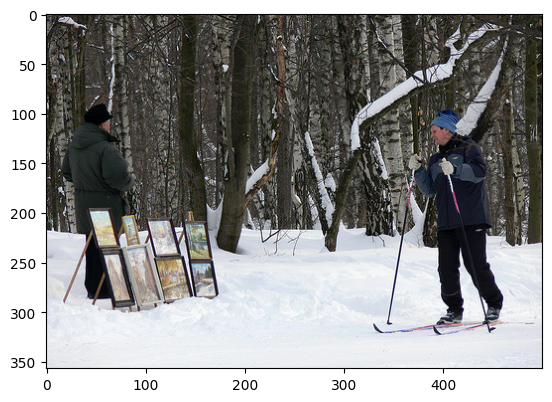

In [30]:
generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Actual---------------------
startseq boy in blue shorts slides down slide into pool endseq
startseq boy in blue swimming trunks slides down yellow slide into wading pool with inflatable toys floating in the water endseq
startseq boy rides down slide into small backyard pool endseq
startseq boy sliding down slide into pool with colorful tubes endseq
startseq child is falling off slide onto colored balloons floating on pool of water endseq
--------------------Predicted--------------------
startseq boy sliding down slide into pool endseq


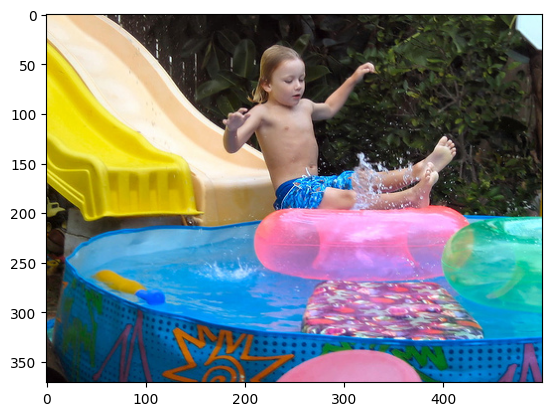

In [26]:
generate_caption("1077546505_a4f6c4daa9.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq little girl covered in front of large painted rainbow endseq


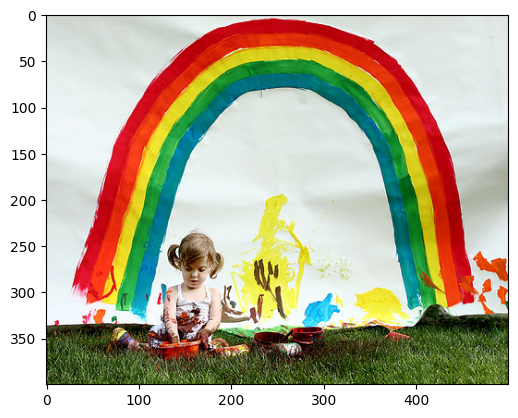

In [27]:
generate_caption("1002674143_1b742ab4b8.jpg")

In [29]:
model.save(output_dir+'/mymodel.h5')